# Exploring DBSCAN with the dataset

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import silhouette_score

import tensorflow_hub as hub
from sklearn.cluster import DBSCAN

plt.rcParams['figure.figsize']=(8.0, 6.0)
%config InlineBackend.figure_format='retina'



[Link to download USE from TensorFlow Hub local source](https://tfhub.dev/google/universal-sentence-encoder/4)



In [ ]:
# Loads Universal Sentence Encoder from TensorFlow Hub online source
#embed = hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')

# Loads Universal Sentence Encoder from TensorFlow Hub local source

embed = hub.load("/Users/data/universal-sentence-encoder_4")


In [4]:


def load_reviews(df_path, product_name):
    '''
    Function to load and embed review content
    '''
    
    # Read in processed file as dataframe
    df = pd.read_csv(df_path)

    # Copy sentence column to new variable
    product_review = df['review_contents'].loc[df['item_name'] == product_name].reset_index(drop=True).copy()

    # Check the numbers of the review
    n = product_review.shape[0]
    
    # Vectorize sentences
    review_vectors = embed(product_review)
    
    return product_review, review_vectors, n

#### Continuing the curiosity from `03_Optimizing_the_k`, we are going to explore the DBSCAN with our example of the dataset
The basic idea of DBSCAN algorithm is to capture the dense regions as clusters and mainly requires two parameters for finding clusters:

    - Epsilon: The maximum distance (euclidean distance) between a pair of points. The two points are considered as neighbours if and only if they are separated by a distance less than or equal to Epsilon
    
    - MinPoints: the minium number of points required to form a dense cluster.
    



In [5]:

# Instantiate an empty list of silhouette scores and cluster counts
product_review, d3_review_vectors, n = load_reviews('data/iherb_best_selling_products_clean_dataset.csv','Vitamin D3 + K2, Soy-Free, 125 mcg (5000 IU), 60 VegCaps')

silhouette_scores = []
n_clusters = []

eps = [0.55, 0.65, 0.75, 0.85, 0.95, 0.15]

# Iterate over eps to check the optimal epsilon
for e in eps:
    
    # Instantiate
    dbscan_model = DBSCAN(eps=e, min_samples=3)

    # Fit
    cluster_labels = dbscan_model.fit_predict(d3_review_vectors)
    
    # Find non-noise points
    non_noise = cluster_labels
    
    # Get silhouette score and number of clusters
    n_cluster = len(np.unique(non_noise))
    
    if n_cluster > 1:
        silhouette = silhouette_score(d3_review_vectors, cluster_labels)
    else:
        silhouette = np.NaN
    
    # Append to list
    n_clusters.append(n_cluster)
    silhouette_scores.append(silhouette)

In [6]:
# Put in a dataframe
pd.DataFrame({'eps':eps, 'n_clusters':n_clusters, 'silhouette':silhouette_scores})

,eps,n_clusters,silhouette
0,0.55,2,0.096189
1,0.65,2,0.096189
2,0.75,4,-0.058273
3,0.85,3,0.000079
4,0.95,3,0.066472
5,0.15,1,NaN


We can see 𝜖=0.25 look promising with 4 identified clusters which matches our intuition for the dataset.

In [8]:
# Instantiate the model (parameters are chosen somewhat at random)
db_model = DBSCAN(eps=0.75, min_samples=3, algorithm='kd_tree')

# Fit the model
db_model.fit(d3_review_vectors)

# Create a series of each data point's label
sentence_labels = pd.Series(db_model.labels_)

# Get total counts of each label
sentence_labels.value_counts()

-1    132
 1      4
 2      3
 0      3
dtype: int64

However, DBSCAN model has classified the huge data points as outliners. There are only 3 clusters left and they have very little data points which won't give us any meaningful insights.

Let's double check the visualization with of this model:

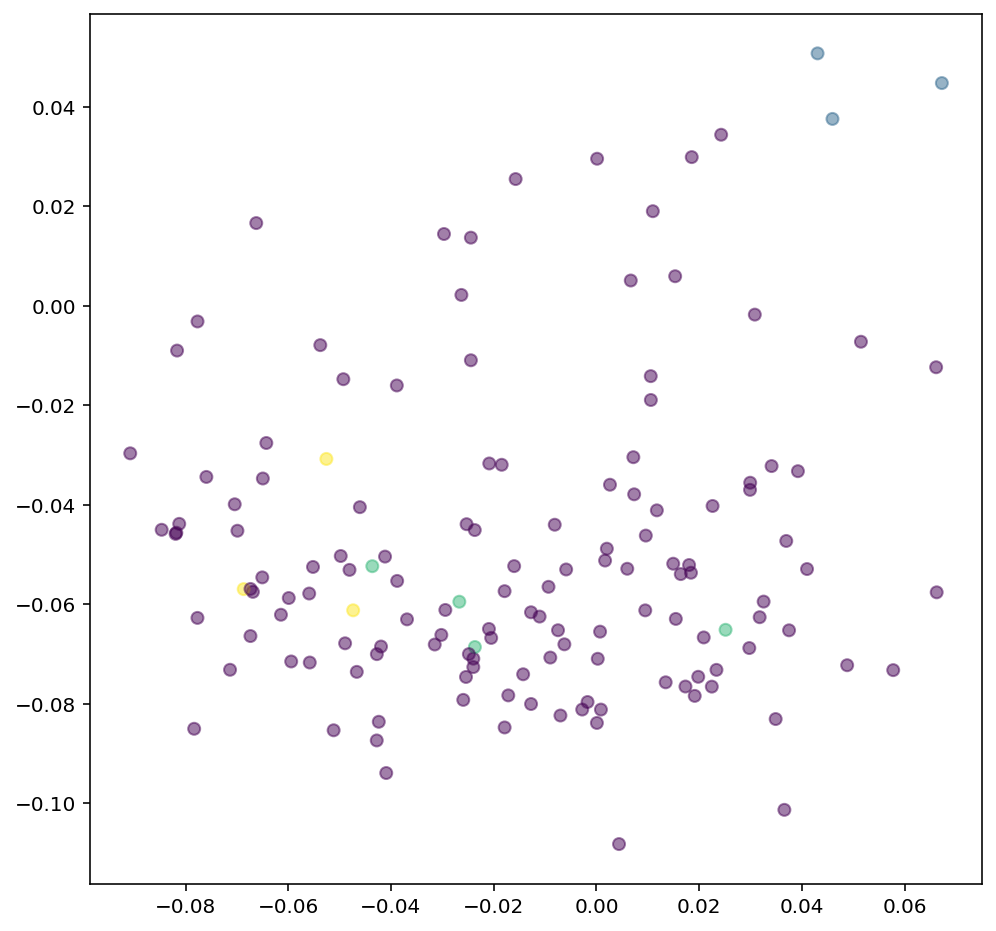

In [10]:

cluster_labels = db_model.fit_predict(d3_review_vectors)

plt.figure(figsize=(8, 8))
plt.scatter(d3_review_vectors[:, 0], d3_review_vectors[:, 1], c=cluster_labels, alpha=0.5)
plt.show()

Let's check the results and see what reviews in 3 clusters:

In [11]:
# Loop through each cluster
for k in range(3):
    
    # Get the indices of all rows with that cluster's label
    indices = sentence_labels[sentence_labels == k].index
    
    # Get the sentences at each of those indices
    cluster_sentences = product_review[indices]
    
    # Pick five sentences at random from set of sentences
    sample_sentences = list(cluster_sentences.sample(3, random_state=14))
    
    print(f'Cluster #{k+1} sentences:\n')
    print(*sample_sentences, sep='\n')
    print('\n')

Cluster #1 sentences:

cool very cool product recommend it
Very very cool product I recommend
Very cool product I recommend it to everyone


Cluster #2 sentences:

Perfect combination of vitamin D and K 2 in 1 very convenient
A good combination of vitamin D and vitamin K. I recommend to everyone
Very good compound - vitamin d plus vitamin Of because vitamin d digest better with k


Cluster #3 sentences:

the dosage is excellent in capsules together with vitamin Of for better absorption the only disadvantage is capsules and vitamin do is still a fat-double vitamin
I recommend these vitamin and try the incredibly cool effect of their use. But To not forget to control the level of vitamin Before and After Capsules with vitamin are not large in size smooth it is very easy to swallow them. His is also an important point since there are vitamin in unrealistically large capsules which you have to choke on when swallowing.
Good dosage and combination of vitamin. I take 1 capsule a day during c

Despite the fact that we only have a very little reviews to check, the model seem to give us semantic review contents in 3 clusters. Therefore, the results that we got from kmeans clustering are insightful and representative of the set of reviews. Moreover, DBSCAN struggles a lot in case of clusters of similar density which is in our case and chooosing the value of 'epsilon' can be difficult espeically when the data is in higher dimensions; hence, we won't use DBSCAN for our problem.

reference: [Let’s cluster data points using DBSCAN](https://medium.com/@agarwalvibhor84/lets-cluster-data-points-using-dbscan-278c5459bee5)